In [ ]:
# import the libraries
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, BatchNormalization, Dropout

import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Nov 23 13:49:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!7z x /content/drive/MyDrive/Classes.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/                                 1 file, 190278912 bytes (182 MiB)

Extracting archive: /content/drive/MyDrive/Classes.zip
 39% 4096 Open              --
Path = /content/drive/MyDrive/Classes.zip
Type = zip
Physical Size = 190278912

  0%      5% 608 - Classes/ No_DR/5141_right.jpeg                                          10% 1034          13% 1347 - Classes/ No_DR/11304_left.jpeg                                           15% 1627 - Classes/ No_

In [ ]:
import pathlib
data_dir = '/content/Classes'
data_dir = pathlib.Path(data_dir)

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpeg')))
print(image_count)

10304


In [ ]:
batch_size = 32
img_height = 224
img_width = 224

In [ ]:
dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    shuffle = True,
    image_size = (img_height, img_width),
    batch_size = batch_size)

Found 10304 files belonging to 2 classes.


In [ ]:
class_names = dataset.class_names
print(class_names)

[' No_DR', 'DR']


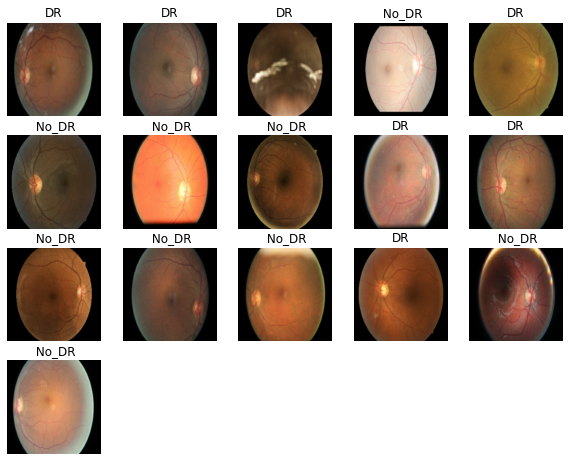

In [ ]:
plt.figure(figsize=(10, 10))
for images_batch, labels_batch in dataset.take(1):
    for i in range(16):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10304 files belonging to 2 classes.
Using 7213 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10304 files belonging to 2 classes.
Using 3091 files for validation.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical", input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.5, seed=None),
    layers.RandomCrop(150, 150, seed=None)
  ]
)

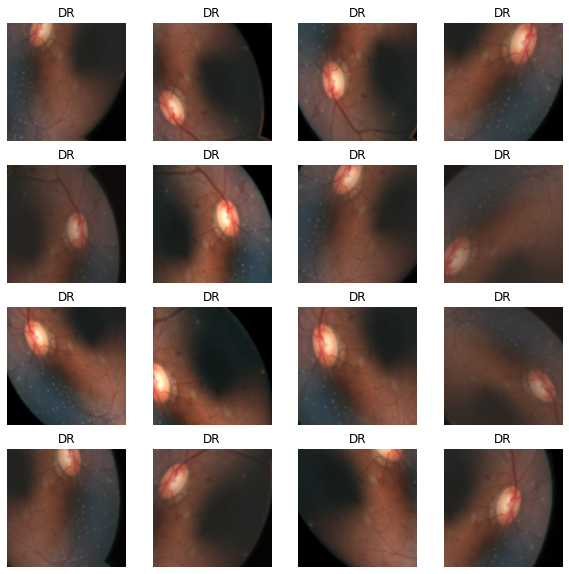

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(16):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[labels[0]])
        plt.axis("off")

In [ ]:
num_classes = len(class_names)

# Transfer Learning

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Model

In [ ]:
base_vgg = model = VGG19(weights='imagenet', include_top=False)
base_vgg.summary()

80134624/80134624 [==============================] - 4s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [ ]:
base_vgg.trainable = False

In [ ]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_vgg(image_batch)
print(feature_batch.shape)

(32, 7, 7, 512)


In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [ ]:
prediction_layer = tf.keras.layers.Dense(8, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 8)


In [ ]:
inputs = keras.Input(shape=(img_height, img_width, 3))
x = base_vgg(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.05)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
import time
start_cnn = time.time()

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

path = 'best_model_TLVGG19.hdf5'
checkpoint = ModelCheckpoint(path, monitor='val_accuracy', verbose = 1, save_best_only = True, mode='max')
es = EarlyStopping(monitor='val_accuracy', patience=10)

callback_list = [checkpoint,es]

In [ ]:
epochs = 100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=callback_list  
)

Epoch 1/100
226/226 [==============================] - ETA: 0s - loss: 1.3249 - accuracy: 0.5098
Epoch 1: val_accuracy improved from -inf to 0.59301, saving model to best_model_TLVGG19.hdf5
226/226 [==============================] - 61s 268ms/step - loss: 1.3249 - accuracy: 0.5098 - val_loss: 0.7757 - val_accuracy: 0.5930
Epoch 2/100
226/226 [==============================] - ETA: 0s - loss: 0.7993 - accuracy: 0.5776
Epoch 2: val_accuracy did not improve from 0.59301
226/226 [==============================] - 56s 249ms/step - loss: 0.7993 - accuracy: 0.5776 - val_loss: 0.8893 - val_accuracy: 0.5257
Epoch 3/100
226/226 [==============================] - ETA: 0s - loss: 0.7424 - accuracy: 0.5959
Epoch 3: val_accuracy did not improve from 0.59301
226/226 [==============================] - 57s 253ms/step - loss: 0.7424 - accuracy: 0.5959 - val_loss: 0.7351 - val_accuracy: 0.5623
Epoch 4/100
226/226 [==============================] - ETA: 0s - loss: 0.6978 - accuracy: 0.6047
Epoch 4: val_ac

In [ ]:
print("Total time: ", time.time() - start_cnn, "seconds")

Total time:  2701.5167739391327 seconds


In [ ]:
scores = model.evaluate(train_ds)

226/226 [==============================] - 41s 181ms/step - loss: 0.6022 - accuracy: 0.6735


In [ ]:
scores = model.evaluate(val_ds)

97/97 [==============================] - 17s 177ms/step - loss: 0.6643 - accuracy: 0.6140


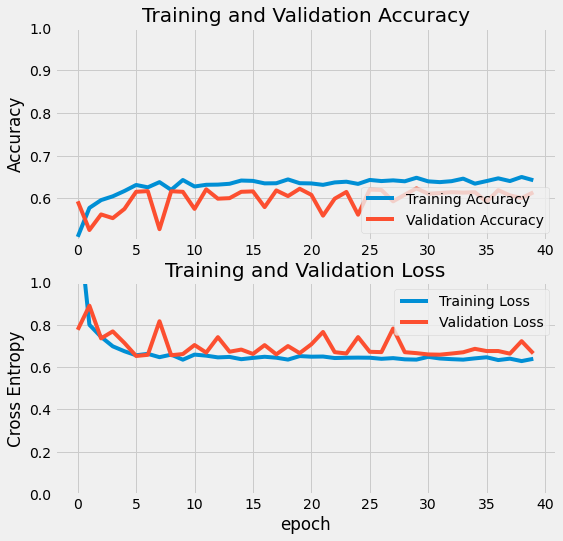

In [ ]:
plt.style.use('fivethirtyeight')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Actual label: DR
1/1 [==============================] - 0s 176ms/step
[2.9885992e-01 7.0114005e-01 8.2486285e-17 5.1838934e-20 1.5046176e-18
 2.3866020e-23 4.0387638e-11 2.9799841e-20]
predicted label: DR


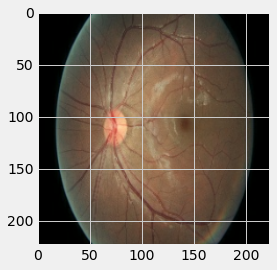

In [ ]:
import numpy as np
for images_batch, labels_batch in val_ds.take(1):
    
    first_image = images_batch[5].numpy().astype('uint8')
    first_label = labels_batch[5].numpy()

    plt.imshow(first_image)
    print("Actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print(batch_prediction[5])
    print("predicted label:",class_names[np.argmax(batch_prediction[5])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 16ms/step


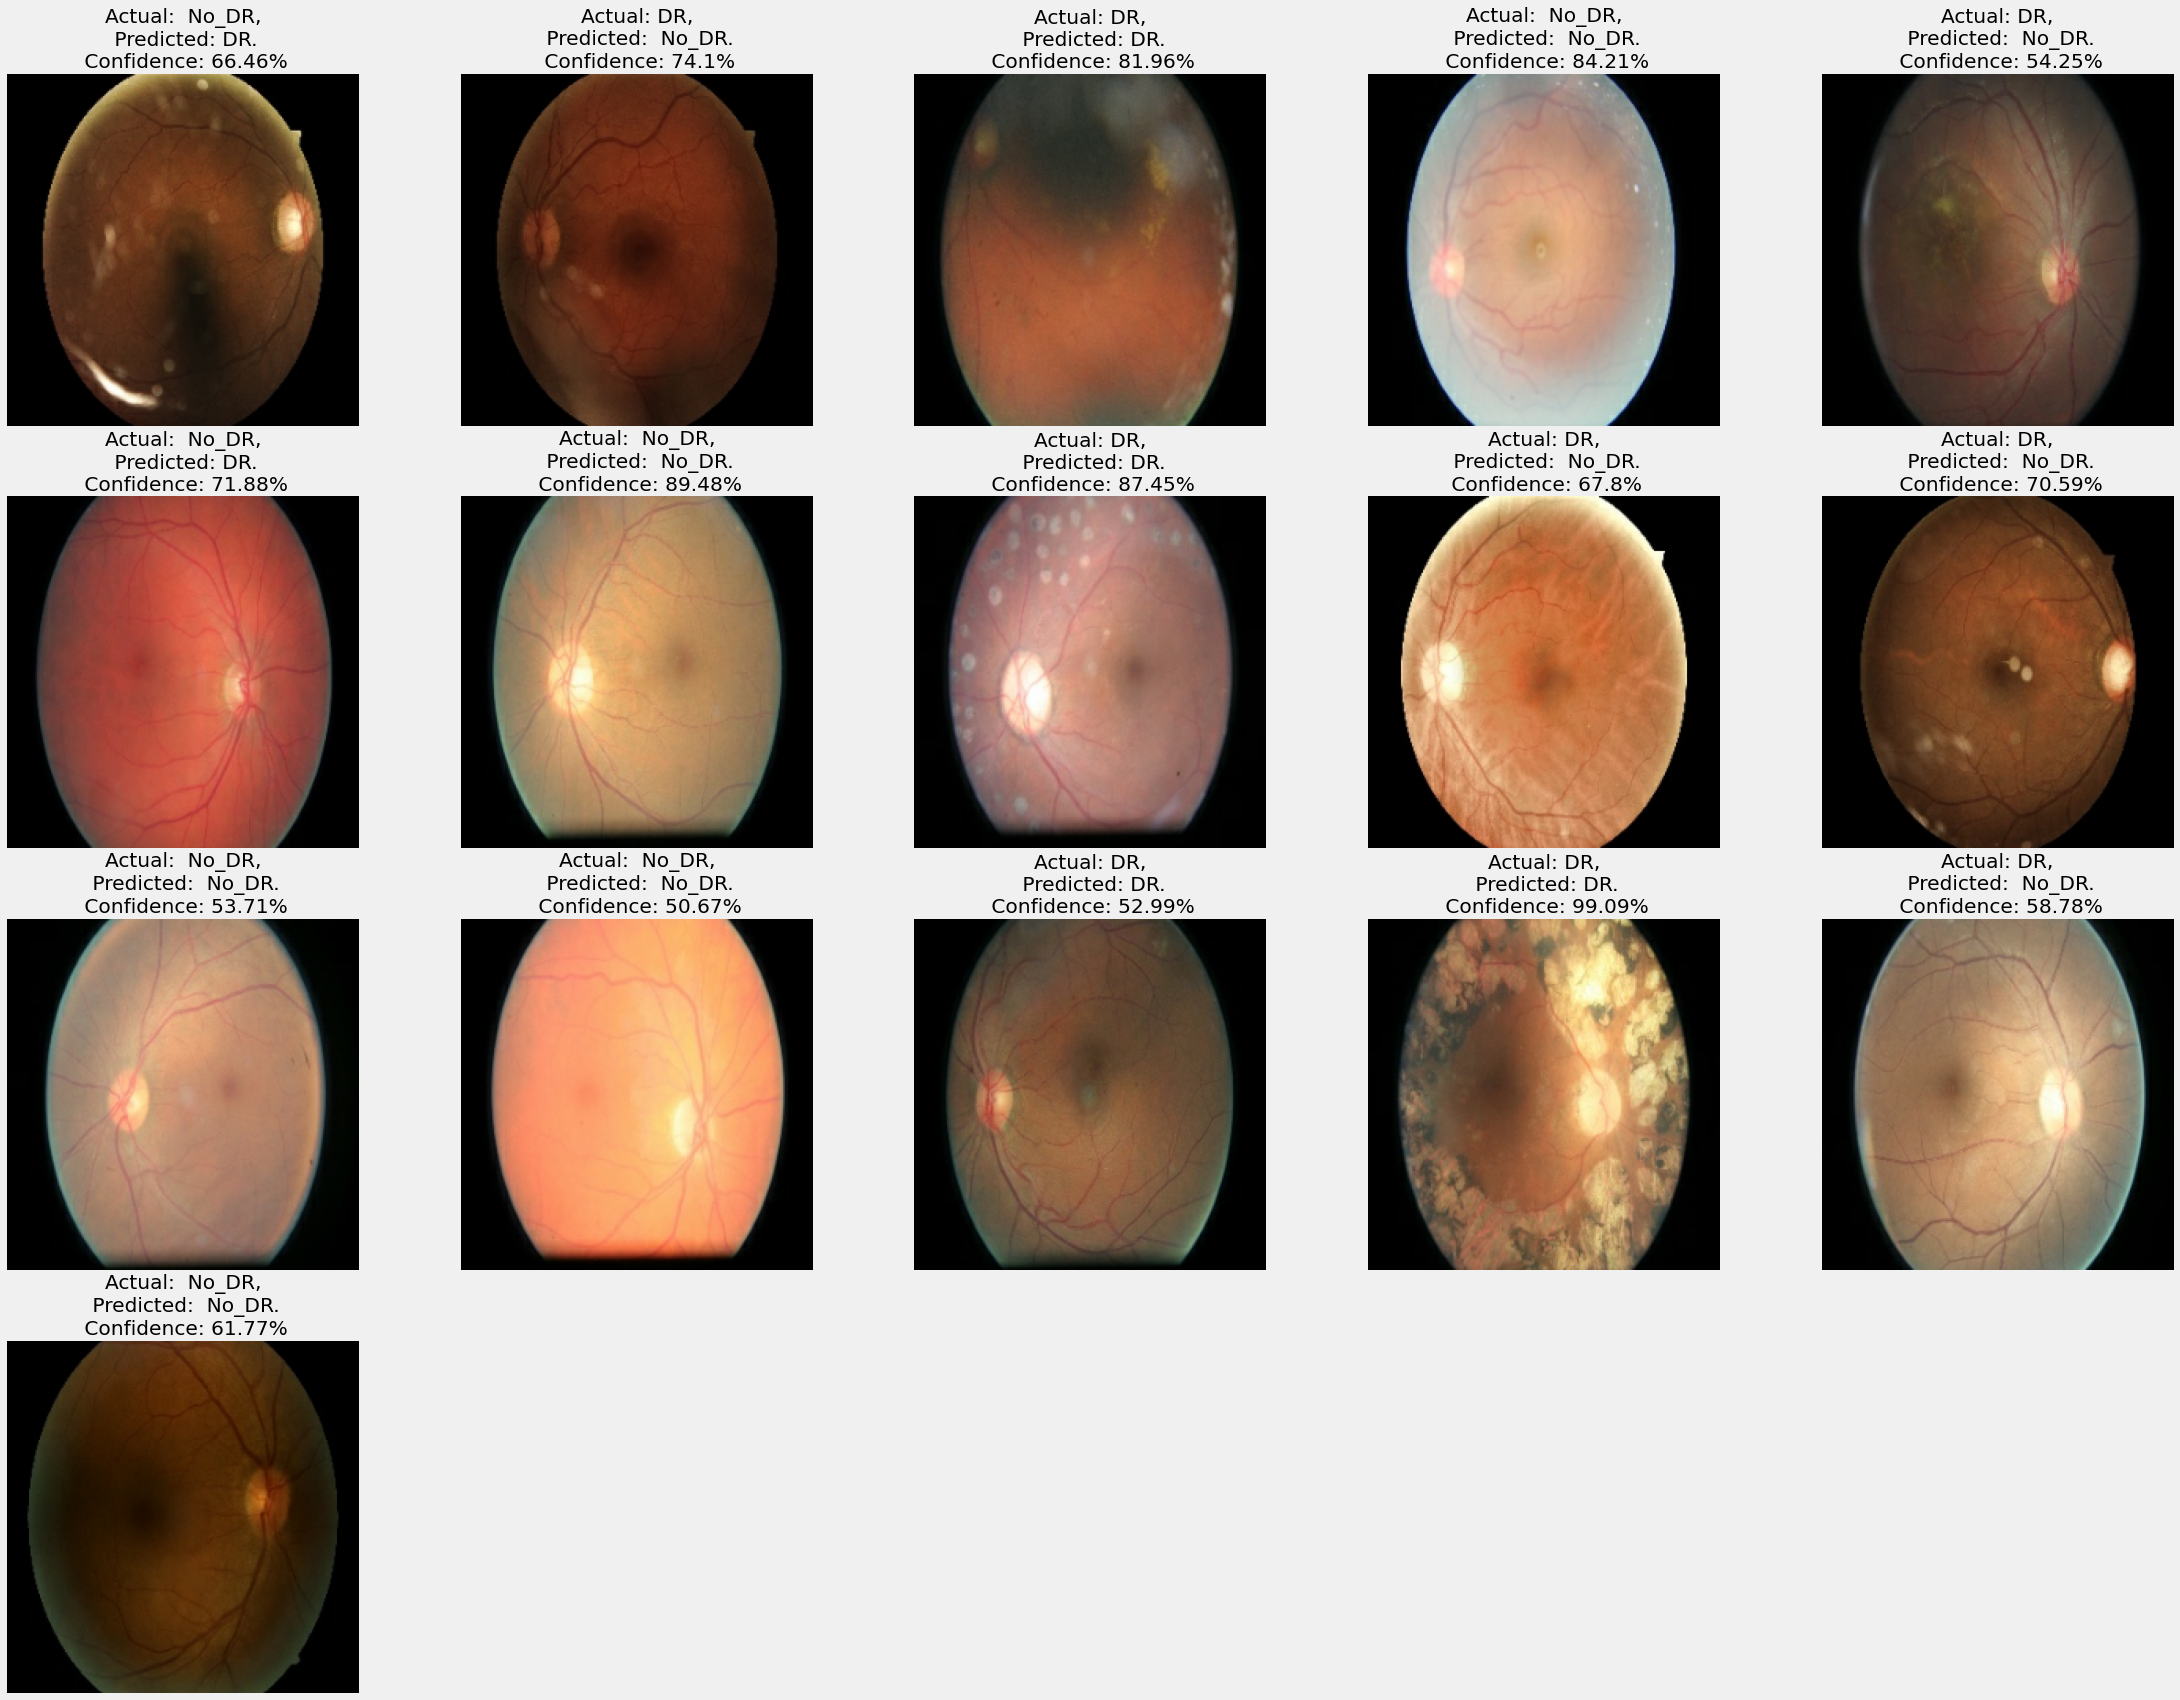

In [55]:
plt.figure(figsize=(35, 35))
for images, labels in val_ds.take(1):
    for i in range(16):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [46]:
X = []
y = []
for image,labels in val_ds.take(96):
    for i in image:
        img = i.numpy()
        X.append(img)
    lbl_list = labels.numpy()    
    y.extend(lbl_list)   

In [47]:
x = np.array(X)

In [48]:
y = np.array(y)

In [49]:
x.shape, y.shape

((3059, 224, 224, 3), (3059,))

In [50]:
model.evaluate(x[:3059],y[:3059])

96/96 [==============================] - 17s 180ms/step - loss: 0.6652 - accuracy: 0.6139


[0.6651615500450134, 0.613926112651825]

In [51]:
from sklearn.metrics import confusion_matrix , classification_report
import numpy as np
y_pred = model.predict(x[:3059])
y_pred_classes = [np.argmax(element) for element in y_pred]
 
print("Classification Report: \n", classification_report(y[:3059], y_pred_classes))

96/96 [==============================] - 17s 177ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.60      0.70      0.65      1545
           1       0.63      0.52      0.57      1514

    accuracy                           0.61      3059
   macro avg       0.62      0.61      0.61      3059
weighted avg       0.62      0.61      0.61      3059



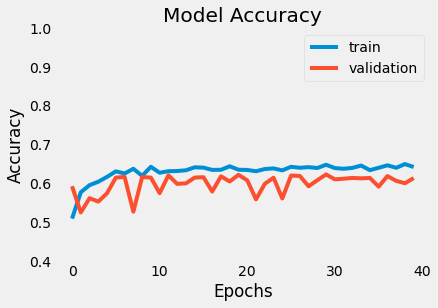

In [56]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()